In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from torchvision.transforms import (
    Compose,
    Resize,
    InterpolationMode,
)
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Preprocessing for SAMed

We could consider this problem in a similar way as we did with the ABUS challenge and train a model to detect abdominal planes (ellipses) inestead of breast lesions.
- As a vanilla version, train the model only with plane frames.

## Only frames with planes

We will save the images as square frames using the largest side (744) as maximum size.<br>
Then, we will resize the images to 512x512 and save them in a new folder.

In [3]:
# Expansion HP
x_expansion = 744
y_expansion = 744
x_resizing = 256
y_resizing = 256
file_format = 'mha'
new_folder_name = f'full-slice_{x_resizing}x{y_resizing}_with-plane'
data_directory = repo_path / 'data/original'
original_im_dir = repo_path / 'data/original/images/stacked_fetal_ultrasound'
original_mask_dir = repo_path / 'data/original/masks/stacked_fetal_abdomen'

In [4]:
# transforms
preprocess_im = Compose(
        [Resize((x_resizing, y_resizing), interpolation= InterpolationMode.BILINEAR),]
)
preprocess_label = Compose(
        [Resize((x_resizing, y_resizing), interpolation= InterpolationMode.NEAREST),]
)
low_res_trans = Compose(
        [Resize((x_resizing//4, y_resizing//4), interpolation= InterpolationMode.NEAREST),]
)

In [5]:
# new images and labels
save_dir = repo_path / 'data/preprocessed' / new_folder_name
im_dir = save_dir / f'images'
label_dir = save_dir / f'masks'
save_dir.mkdir(exist_ok=True)
im_dir.mkdir(exist_ok=True)
label_dir.mkdir(exist_ok=True)
metadata = pd.read_csv(repo_path / 'data/original/metadata.csv')
metadata.head()

,uuid,subject_id,sweep_1_ac_mm,sweep_2_ac_mm,sweep_3_ac_mm,sweep_4_ac_mm,sweep_5_ac_mm,sweep_6_ac_mm,z_values_opt,z_values_subopt
0,2e99ee0e-506a-443b-8c16-e8a0619da2f7,0,579.217706,NaN,NaN,NaN,NaN,NaN,6,3
1,bfd442e7-9299-4890-ad3d-c9d5b6534cbc,1,NaN,NaN,NaN,NaN,519.406363,NaN,0,11
2,0199616b-bdeb-4119-97a3-a5a3571bd641,2,624.540028,NaN,NaN,NaN,587.598341,NaN,0,19
3,dcdcb9a4-fec7-45a2-b2b7-a282f963c551,2,398.869800,NaN,NaN,NaN,NaN,NaN,0,10
4,484c03b0-441d-4966-b10e-06b31d84e55e,3,614.922733,NaN,NaN,NaN,NaN,NaN,0,2


In [12]:
ex_row = metadata.iloc[0].copy()
ex_name = ex_row['uuid'] + '.' + file_format
image_path = original_im_dir / ex_name
label_path = original_mask_dir / ex_name
assert image_path.exists() and label_path.exists()
# get image and label
im = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
label = sitk.GetArrayFromImage(sitk.ReadImage(label_path))

# now, we complete the images and labels to the expansion variables
if im.shape[2]<x_expansion:
    print('Expanding x dimension')
    im = np.concatenate((im, np.zeros((im.shape[0], im.shape[1], x_expansion-im.shape[2]), dtype=np.int8)), axis=2)
    label = np.concatenate((label, np.zeros((label.shape[0], label.shape[1], x_expansion-label.shape[2]), dtype=np.int8)), axis=2)

if im.shape[1]<y_expansion:
    print('Expanding y dimension')
    im = np.concatenate((im, np.zeros((im.shape[0], y_expansion-im.shape[1], im.shape[2]), dtype=np.int8)), axis=1)
    label = np.concatenate((label, np.zeros((label.shape[0], y_expansion-label.shape[1], label.shape[2]), dtype=np.int8)), axis=1)

# z values wıth plane
z_values = np.unique(np.where(label>0)[0])
for z in z_values:
    # preprocess image
    im_slice = Image.fromarray(im[z])
    im_slice = preprocess_im(im_slice)
    im_slice = np.asarray(im_slice)
    # put channel first and repeat in RGB
    im_slice = np.repeat(np.expand_dims(im_slice, axis=0), 3, axis=0)
    # im_slice = im_slice.astype(np.uint8)

    # preprocess label
    label_slice = Image.fromarray(label[z])
    label_slice = preprocess_label(label_slice)
    # low resolution is needed for checking if there is still a lesion
    low_label_slice = low_res_trans(label_slice)
    low_label_slice = np.asarray(low_label_slice)
    label_slice = np.asarray(label_slice).astype(np.uint32)
    plane_type = label_slice.max()
    # send label value to 255
    label_slice[label_slice>0] = 255
    # check if there is still a lesion
    if not np.any(label_slice): # it could disappear after preprocessing
        print(f'Nothing in the label')
        continue
    if not np.any(low_label_slice): # it could disappear after low resolution
        print(f'Nothing in the low label')
        continue

# saving path
save_name = ex_name.replace('.mha', f'_z{z}_plane_{plane_type}.mha')
# save image
sitk.WriteImage(sitk.GetImageFromArray(im_slice), str(im_dir / save_name))
# save label
sitk.WriteImage(sitk.GetImageFromArray(label_slice), str(label_dir / save_name))

Expanding y dimension


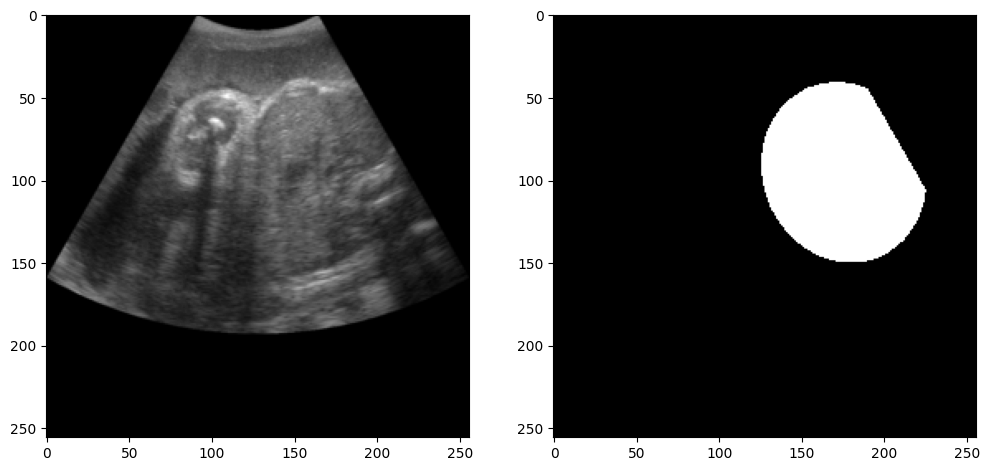

In [7]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(im_slice[2], cmap='gray')
ax[1].imshow(label_slice, cmap='gray')
plt.show()